# Automobile Mutual Information

---

## Reference

> [Mutual Information](https://www.kaggle.com/ryanholbrook/mutual-information)<br>
> [Data Source](https://www.kaggle.com/ryanholbrook/fe-course-data)

---

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")

%load_ext autotime

time: 205 µs (started: 2021-08-15 16:20:14 -07:00)


---

## Import Dataset

The [Automobile](https://www.kaggle.com/toramky/automobile-dataset) dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

In [2]:
df = pd.read_csv("data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


time: 31.6 ms (started: 2021-08-15 16:20:14 -07:00)


---

## Mutual Information

The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding.

> [pandas.factorize](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html)

In [3]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes(include=["object"]):
    X[colname], _ = X[colname].factorize()
    
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

time: 8.34 ms (started: 2021-08-15 16:20:14 -07:00)


Scikit-learn has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [4]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
#mi_scores[::3]  # show a few features with their MI scores
mi_scores

curb_weight          1.481331
horsepower           1.267067
engine_size          1.001285
highway_mpg          0.953907
city_mpg             0.858209
width                0.679281
length               0.613038
wheel_base           0.586890
make                 0.544564
fuel_system          0.484845
bore                 0.483792
peak_rpm             0.445218
stroke               0.378065
height               0.355960
drive_wheels         0.332213
num_of_cylinders     0.331445
symboling            0.228353
engine_type          0.150298
compression_ratio    0.131906
aspiration           0.087994
body_style           0.080009
fuel_type            0.048120
engine_location      0.036912
num_of_doors         0.012705
Name: MI Scores, dtype: float64

time: 140 ms (started: 2021-08-15 16:20:14 -07:00)


And sure enough, performance improved! This is evidence that these new ratio features exposed important information to the model that it wasn't detecting before.

And now a bar plot to make comparisions easier:

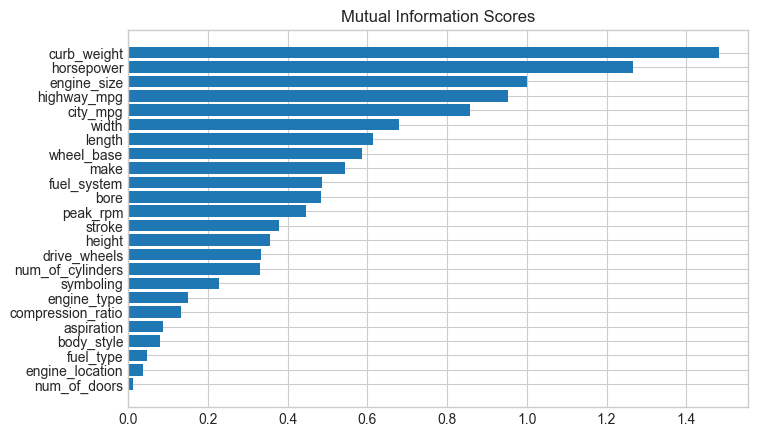

time: 252 ms (started: 2021-08-15 16:20:14 -07:00)


In [5]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.

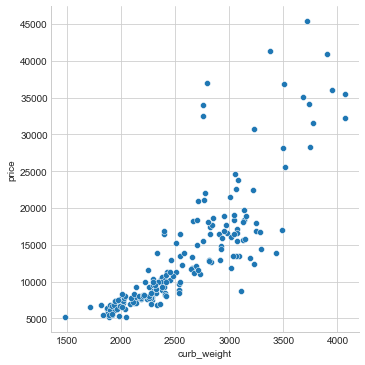

time: 190 ms (started: 2021-08-15 16:20:14 -07:00)


In [6]:
sns.relplot(x="curb_weight", y="price", data=df);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

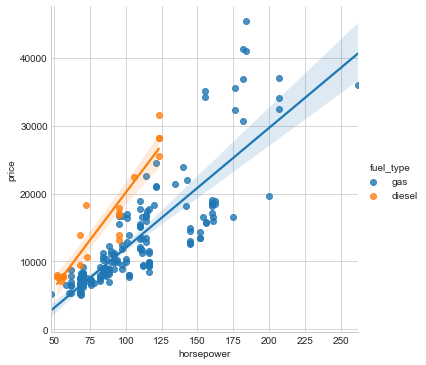

time: 426 ms (started: 2021-08-15 16:20:14 -07:00)


In [7]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

Data visualization is a great addition to your feature-engineering toolbox. Along with utility metrics like mutual information, visualizations like these can help you discover important relationships in your data.